In [1]:
## Standard libraries
import os
import numpy as np
from PIL import Image
from typing import Any
from collections import defaultdict
import time

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0


## To run JAX on TPU in Google Colab, uncomment the two lines below
# import jax.tools.colab_tpu
# jax.tools.colab_tpu.setup_tpu()

## JAX
import jax
import jax.numpy as jnp
from jax import random
# Seeding for random operations
main_rng = random.PRNGKey(42)

## Flax (NN in JAX)
try:
    import flax
except ModuleNotFoundError: # Install flax if missing
    !pip install --quiet flax
    import flax
from flax import linen as nn
from flax.training import train_state, checkpoints
import orbax
from orbax import checkpoint
from flax.training import orbax_utils

## Optax (Optimizers in JAX)
try:
    import optax
except ModuleNotFoundError: # Install optax if missing
    !pip install --quiet optax
    import optax

## PyTorch
import torch
import torch.utils.data as data
import torchvision
from torchvision import transforms
from torchvision.datasets import CIFAR10

/tmp/ipykernel_1537994/2670370047.py:13: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


In [2]:
import os
import sys
import jax
import zipfile
import jax.numpy as jnp
import optax
import torch
from tqdm.notebook import tqdm
from torch.utils.tensorboard import SummaryWriter
import torchvision.transforms as T
import pandas as pd
import numpy as np
import argparse

from jax.example_libraries import optimizers
from sklearn.metrics import average_precision_score
from PIL import Image
from torch.utils.data import DataLoader
from torch.utils import data
from urllib import request
from typing import Tuple
from torch.utils.data import Dataset
from flax.struct import dataclass
from jax.tree_util import tree_map
from evojax.task.base import VectorizedTask
from evojax.task.base import TaskState

In [4]:
print("Device:", jax.devices())

Device: [gpu(id=0), gpu(id=1)]


In [5]:
# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = './data/'
CHECKPOINT_PATH = '/home/gh0st/projects/evojax/notebook_output/saved_models'

In [6]:
os.fspath(CHECKPOINT_PATH)

'/home/gh0st/projects/evojax/notebook_output/saved_models'

In [7]:
train_dataset = CIFAR10(root=DATASET_PATH, train=True, download=True)
DATA_MEANS = (train_dataset.data / 255.0).mean(axis=(0,1,2))
DATA_STD = (train_dataset.data / 255.0).std(axis=(0,1,2))
print("Data mean", DATA_MEANS)
print("Data std", DATA_STD)

Files already downloaded and verified
Data mean [0.49139968 0.48215841 0.44653091]
Data std [0.24703223 0.24348513 0.26158784]


In [8]:
# Transformations applied on each image => bring them into a numpy array
def image_to_numpy(img):
    img = np.array(img, dtype=np.float32)
    img = (img / 255. - DATA_MEANS) / DATA_STD
    return img

# We need to stack the batch elements
def numpy_collate(batch):
    if isinstance(batch[0], np.ndarray):
        return np.stack(batch)
    elif isinstance(batch[0], (tuple,list)):
        transposed = zip(*batch)
        return [numpy_collate(samples) for samples in transposed]
    else:
        return np.array(batch)


test_transform = image_to_numpy
# For training, we add some augmentation. Networks are too powerful and would overfit.
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                      transforms.RandomResizedCrop((32,32),scale=(0.8,1.0),ratio=(0.9,1.1)),
                                      image_to_numpy
                                     ])
# Loading the training dataset. We need to split it into a training and validation part
# We need to do a little trick because the validation set should not use the augmentation.
train_dataset = CIFAR10(root=DATASET_PATH, train=True, transform=train_transform, download=True)
val_dataset = CIFAR10(root=DATASET_PATH, train=True, transform=test_transform, download=True)
train_set, _ = torch.utils.data.random_split(train_dataset, [45000, 5000], generator=torch.Generator().manual_seed(42))
_, val_set = torch.utils.data.random_split(val_dataset, [45000, 5000], generator=torch.Generator().manual_seed(42))

# Loading the test set
test_set = CIFAR10(root=DATASET_PATH, train=False, transform=test_transform, download=True)

# We define a set of data loaders that we can use for training and validation
train_loader = data.DataLoader(train_set,
                               batch_size=128,
                               shuffle=True,
                               drop_last=True,
                               collate_fn=numpy_collate,
                               num_workers=8,
                               persistent_workers=True)
val_loader   = data.DataLoader(val_set,
                               batch_size=128,
                               shuffle=False,
                               drop_last=False,
                               collate_fn=numpy_collate,
                               num_workers=4,
                               persistent_workers=True)
test_loader  = data.DataLoader(test_set,
                               batch_size=128,
                               shuffle=False,
                               drop_last=False,
                               collate_fn=numpy_collate,
                               num_workers=4,
                               persistent_workers=True)


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [9]:
imgs, _ = next(iter(train_loader))
print("Batch mean", imgs.mean(axis=(0,1,2)))
print("Batch std", imgs.std(axis=(0,1,2)))

Batch mean [ 0.01389681  0.01511452 -0.00052855]
Batch std [0.97128042 0.99114585 1.01040982]


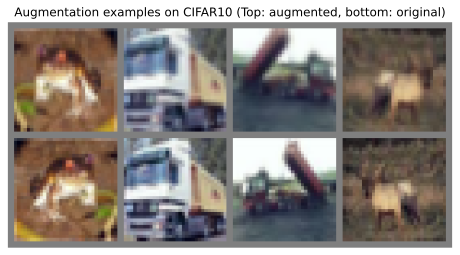

In [10]:
NUM_IMAGES = 4
images = [train_dataset[idx][0] for idx in range(NUM_IMAGES)]
orig_images = [Image.fromarray(train_dataset.data[idx]) for idx in range(NUM_IMAGES)]
orig_images = [test_transform(img) for img in orig_images]

imgs = np.stack(images + orig_images, axis=0)
imgs = torch.from_numpy(imgs).permute(0, 3, 1, 2)
img_grid = torchvision.utils.make_grid(imgs, nrow=4, normalize=True, pad_value=0.5)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8,8))
plt.title("Augmentation examples on CIFAR10 (Top: augmented, bottom: original)")
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

In [11]:
class TrainState(train_state.TrainState):
    # A simple extension of TrainState to also include batch statistics
    batch_stats: Any

In [12]:
class TrainerModule:

    def __init__(self,
                 model_name : str,
                 model_class : nn.Module,
                 model_hparams : dict,
                 optimizer_name : str,
                 optimizer_hparams : dict,
                 exmp_imgs : Any,
                 seed=42):
        """
        Module for summarizing all training functionalities for classification on CIFAR10.

        Inputs:
            model_name - String of the class name, used for logging and saving
            model_class - Class implementing the neural network
            model_hparams - Hyperparameters of the model, used as input to model constructor
            optimizer_name - String of the optimizer name, supporting ['sgd', 'adam', 'adamw']
            optimizer_hparams - Hyperparameters of the optimizer, including learning rate as 'lr'
            exmp_imgs - Example imgs, used as input to initialize the model
            seed - Seed to use in the model initialization
        """
        super().__init__()
        self.model_name = model_name
        self.model_class = model_class
        self.model_hparams = model_hparams
        self.optimizer_name = optimizer_name
        self.optimizer_hparams = optimizer_hparams
        self.seed = seed
        # Create empty model. Note: no parameters yet
        self.model = self.model_class(**self.model_hparams)
        # Prepare logging
        self.log_dir = os.path.join(CHECKPOINT_PATH, self.model_name)
        self.logger = SummaryWriter(log_dir=self.log_dir)
        # Create jitted training and eval functions
        self.create_functions()
        # Initialize model
        self.init_model(exmp_imgs)

        # Initialize the PyTreeCheckpointer and CheckpointManager
        self.orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()
        options = orbax.checkpoint.CheckpointManagerOptions(max_to_keep=2, create=True)
        self.checkpoint_manager = orbax.checkpoint.CheckpointManager(
            self.log_dir, self.orbax_checkpointer, options)


    def create_functions(self):
        # Function to calculate the classification loss and accuracy for a model
        def calculate_loss(params, batch_stats, batch, train):
            imgs, labels = batch
            # Run model. During training, we need to update the BatchNorm statistics.
            outs = self.model.apply({'params': params, 'batch_stats': batch_stats},
                                    imgs,
                                    train=train,
                                    mutable=['batch_stats'] if train else False)
            logits, new_model_state = outs if train else (outs, None)
            loss = optax.softmax_cross_entropy_with_integer_labels(logits, labels).mean()
            acc = (logits.argmax(axis=-1) == labels).mean()
            return loss, (acc, new_model_state)
        # Training function
        def train_step(state, batch):
            loss_fn = lambda params: calculate_loss(params, state.batch_stats, batch, train=True)
            # Get loss, gradients for loss, and other outputs of loss function
            ret, grads = jax.value_and_grad(loss_fn, has_aux=True)(state.params)
            loss, acc, new_model_state = ret[0], *ret[1]
            # Update parameters and batch statistics
            state = state.apply_gradients(grads=grads, batch_stats=new_model_state['batch_stats'])
            return state, loss, acc
        # Eval function
        def eval_step(state, batch):
            # Return the accuracy for a single batch
            _, (acc, _) = calculate_loss(state.params, state.batch_stats, batch, train=False)
            return acc
        # jit for efficiency
        self.train_step = jax.jit(train_step)
        self.eval_step = jax.jit(eval_step)

    def init_model(self, exmp_imgs):
        # Initialize model
        init_rng = jax.random.PRNGKey(self.seed)
        variables = self.model.init(init_rng, exmp_imgs, train=True)
        self.init_params, self.init_batch_stats = variables['params'], variables['batch_stats']
        self.state = None

    def init_optimizer(self, num_epochs, num_steps_per_epoch):
        # Initialize learning rate schedule and optimizer
        if self.optimizer_name.lower() == 'adam':
            opt_class = optax.adam
        elif self.optimizer_name.lower() == 'adamw':
            opt_class = optax.adamw
        elif self.optimizer_name.lower() == 'sgd':
            opt_class = optax.sgd
        else:
            assert False, f'Unknown optimizer "{opt_class}"'
        # We decrease the learning rate by a factor of 0.1 after 60% and 85% of the training
        lr_schedule = optax.piecewise_constant_schedule(
            init_value=self.optimizer_hparams.pop('lr'),
            boundaries_and_scales=
                {int(num_steps_per_epoch*num_epochs*0.6): 0.1,
                 int(num_steps_per_epoch*num_epochs*0.85): 0.1}
        )
        # Clip gradients at max value, and evt. apply weight decay
        transf = [optax.clip(1.0)]
        if opt_class == optax.sgd and 'weight_decay' in self.optimizer_hparams:  # wd is integrated in adamw
            transf.append(optax.add_decayed_weights(self.optimizer_hparams.pop('weight_decay')))
        optimizer = optax.chain(
            *transf,
            opt_class(lr_schedule, **self.optimizer_hparams)
        )
        # Initialize training state
        self.state = TrainState.create(apply_fn=self.model.apply,
                                       params=self.init_params if self.state is None else self.state.params,
                                       batch_stats=self.init_batch_stats if self.state is None else self.state.batch_stats,
                                       tx=optimizer)

    def train_model(self, train_loader, val_loader, num_epochs=200):
        # Train model for defined number of epochs
        # We first need to create optimizer and the scheduler for the given number of epochs
        self.init_optimizer(num_epochs, len(train_loader))
        # Track best eval accuracy
        best_eval = 0.0
        for epoch_idx in tqdm(range(1, num_epochs+1)):
            self.train_epoch(train_loader, epoch=epoch_idx)
            if epoch_idx % 2 == 0:
                eval_acc = self.eval_model(val_loader)
                self.logger.add_scalar('val/acc', eval_acc, global_step=epoch_idx)
                if eval_acc >= best_eval:
                    best_eval = eval_acc
                    self.save_model(step=epoch_idx)
                self.logger.flush()

    def train_epoch(self, train_loader, epoch):
        # Train model for one epoch, and log avg loss and accuracy
        metrics = defaultdict(list)
        for batch in tqdm(train_loader, desc='Training', leave=False):
            self.state, loss, acc = self.train_step(self.state, batch)
            metrics['loss'].append(loss)
            metrics['acc'].append(acc)
        for key in metrics:
            avg_val = np.stack(jax.device_get(metrics[key])).mean()
            self.logger.add_scalar('train/'+key, avg_val, global_step=epoch)

    def eval_model(self, data_loader):
        # Test model on all images of a data loader and return avg loss
        correct_class, count = 0, 0
        for batch in data_loader:
            acc = self.eval_step(self.state, batch)
            correct_class += acc * batch[0].shape[0]
            count += batch[0].shape[0]
        eval_acc = (correct_class / count).item()
        return eval_acc

    def save_model(self, step=0):

        # Assuming 'self.state' contains the model state you want to save
        ckpt = {'params': self.state.params, 'batch_stats': self.state.batch_stats}

        # Get save_args for performance optimization
        save_args = orbax_utils.save_args_from_target(ckpt)

        # Save the checkpoint using the checkpoint manager
        self.checkpoint_manager.save(step, ckpt, save_kwargs={'save_args': save_args})

        # Save current model at certain training iteration
        #checkpoints.save_checkpoint(ckpt_dir=self.log_dir,
        #                            target={'params': self.state.params,
        #                                    'batch_stats': self.state.batch_stats},
        #                            step=step,
        #                           overwrite=True)

    def load_model(self, pretrained=False):
        # Load model. We use different checkpoint for pretrained models
        if not pretrained:
            state_dict = checkpoints.restore_checkpoint(ckpt_dir=self.log_dir, target=None)
        else:
            state_dict = checkpoints.restore_checkpoint(ckpt_dir=os.path.join(CHECKPOINT_PATH, f'{self.model_name}.ckpt'), target=None)
        self.state = TrainState.create(apply_fn=self.model.apply,
                                       params=state_dict['params'],
                                       batch_stats=state_dict['batch_stats'],
                                       tx=self.state.tx if self.state else optax.sgd(0.1)   # Default optimizer
                                      )

    def checkpoint_exists(self):
        # Check whether a pretrained model exist for this autoencoder
        return os.path.isfile(os.path.join(CHECKPOINT_PATH, f'{self.model_name}.ckpt'))

In [13]:
def train_classifier(*args, num_epochs=200, **kwargs):
    # Create a trainer module with specified hyperparameters
    trainer = TrainerModule(*args, **kwargs)
    if not trainer.checkpoint_exists():  # Skip training if pretrained model exists
        trainer.train_model(train_loader, val_loader, num_epochs=num_epochs)
        trainer.load_model()
    else:
        trainer.load_model(pretrained=True)
    # Test trained model
    val_acc = trainer.eval_model(val_loader)
    test_acc = trainer.eval_model(test_loader)
    return trainer, {'val': val_acc, 'test': test_acc}

In [14]:
densenet_kernel_init = nn.initializers.kaiming_normal()

class DenseLayer(nn.Module):
    bn_size : int  # Bottleneck size (factor of growth rate) for the output of the 1x1 convolution
    growth_rate : int  # Number of output channels of the 3x3 convolution
    act_fn : callable  # Activation function

    @nn.compact
    def __call__(self, x, train=True):
        z = nn.BatchNorm()(x, use_running_average=not train)
        z = self.act_fn(z)
        z = nn.Conv(self.bn_size * self.growth_rate,
                    kernel_size=(1, 1),
                    kernel_init=densenet_kernel_init,
                    use_bias=False)(z)
        z = nn.BatchNorm()(z, use_running_average=not train)
        z = self.act_fn(z)
        z = nn.Conv(self.growth_rate,
                    kernel_size=(3, 3),
                    kernel_init=densenet_kernel_init,
                    use_bias=False)(z)
        x_out = jnp.concatenate([x, z], axis=-1)
        return x_out

In [15]:
class DenseBlock(nn.Module):
    num_layers : int  # Number of dense layers to apply in the block
    bn_size : int  # Bottleneck size to use in the dense layers
    growth_rate : int  # Growth rate to use in the dense layers
    act_fn : callable  # Activation function to use in the dense layers

    @nn.compact
    def __call__(self, x, train=True):
        for _ in range(self.num_layers):
            x = DenseLayer(bn_size=self.bn_size,
                           growth_rate=self.growth_rate,
                           act_fn=self.act_fn)(x, train=train)
        return x

In [16]:
class TransitionLayer(nn.Module):
    c_out : int  # Output feature size
    act_fn : callable  # Activation function

    @nn.compact
    def __call__(self, x, train=True):
        x = nn.BatchNorm()(x, use_running_average=not train)
        x = self.act_fn(x)
        x = nn.Conv(self.c_out,
                    kernel_size=(1, 1),
                    kernel_init=densenet_kernel_init,
                    use_bias=False)(x)
        x = nn.avg_pool(x, (2, 2), strides=(2, 2))
        return x

In [17]:
class DenseNet(nn.Module):
    num_classes : int
    act_fn : callable = nn.relu
    num_layers : tuple = (6, 12, 24, 16)
    bn_size : int = 4
    growth_rate : int = 32

    @nn.compact
    def __call__(self, x, train=True):
        c_hidden = self.growth_rate * self.bn_size  # The start number of hidden channels
        
        x = jnp.pad(x, pad_width=((0, 0), (3, 3), (3, 3), (0, 0)))  # Zero padding
        x = nn.Conv(64, (7, 7), strides=(2, 2), padding='VALID', 
                    kernel_init=densenet_kernel_init)(x)
        x = nn.BatchNorm()(x, use_running_average=not train)
        x = self.act_fn(x)
        x = jnp.pad(x, pad_width=((0, 0), (1, 1), (1, 1), (0, 0)))  # Zero padding for max pooling
        x = nn.max_pool(x, window_shape=(3, 3), strides=(2, 2), padding='VALID')

        for block_idx, num_layers in enumerate(self.num_layers):
            x = DenseBlock(num_layers=num_layers,
                           bn_size=self.bn_size,
                           growth_rate=self.growth_rate,
                           act_fn=self.act_fn)(x, train=train)
            c_hidden += num_layers * self.growth_rate
            if block_idx < len(self.num_layers)-1:  # Don't apply transition layer on last block
                x = TransitionLayer(c_out=c_hidden//2,
                                    act_fn=self.act_fn)(x, train=train)
                c_hidden //= 2

        x = nn.BatchNorm()(x, use_running_average=not train)
        x = self.act_fn(x)
        x = x.mean(axis=(1, 2))
        x = nn.Dense(self.num_classes)(x)
        return x

In [18]:
densenet_trainer, densenet_results = train_classifier(model_name="DenseNet",
                                                      model_class=DenseNet,
                                                      model_hparams={"num_classes": 10,
                                                                     "num_layers": [6, 12, 24, 16],
                                                                     "bn_size": 4,
                                                                     "growth_rate": 32,
                                                                     "act_fn": nn.relu},
                                                      optimizer_name="adamw",
                                                      optimizer_hparams={"lr": 1e-3,
                                                                         "weight_decay": 1e-4},
                                                      exmp_imgs=jax.device_put(
                                                          next(iter(train_loader))[0]),
                                                      num_epochs=200)

  0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

TypeError: 'NoneType' object is not subscriptable

In [3]:
print(jax.__version__)

0.4.14


In [27]:
# Load tensorboard extension
%reload_ext tensorboard

In [28]:
%tensorboard --logdir ./notebook_output/saved_models/DenseNet

Reusing TensorBoard on port 6006 (pid 1562252), started 0:15:14 ago. (Use '!kill 1562252' to kill it.)